# 1. Gather data, determine the method of data collection and provenance of the data

An automobile company has plans to enter new markets with their existing products (P1, P2, P3, P4, and P5). After intensive market research, they’ve deduced that the behavior of the new market is similar to their existing market.
https://www.kaggle.com/datasets/kaushiksuresh147/customer-segmentation?datasetId=841888

# 2. Identify an Unsupervised Learning Problem
In their existing market, the sales team has classified all customers into 4 segments (A, B, C, D). Then, they performed segmented outreach and communication for a different segment of customers. This strategy has work exceptionally well for them. They plan to use the same strategy for the new markets and have identified 2627 new potential customers.

# 3. Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from hyperopt import hp, STATUS_OK, Trials, fmin, tpe
import itertools

In [62]:
df = pd.read_csv("./data/Train.csv")
test_data = pd.read_csv("./data/Test.csv")

In [63]:
df.shape

(8068, 11)

In [64]:
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [65]:
df.describe()

,ID,Age,Work_Experience,Family_Size
count,8068.000000,8068.000000,7239.000000,7733.000000
mean,463479.214551,43.466906,2.641663,2.850123
std,2595.381232,16.711696,3.406763,1.531413
min,458982.000000,18.000000,0.000000,1.000000
25%,461240.750000,30.000000,0.000000,2.000000
50%,463472.500000,40.000000,1.000000,3.000000
75%,465744.250000,53.000000,4.000000,4.000000
max,467974.000000,89.000000,14.000000,9.000000


## Visualization
For each factor, use a box-plot, scatter plot, histogram, etc., to describe the data distribution as appropriate.

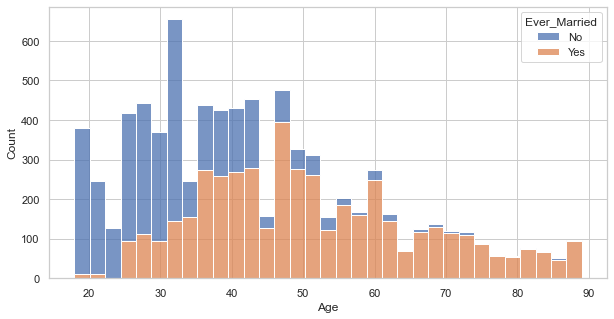

In [66]:
f, ax = plt.subplots(figsize=(10, 5))
ax = sns.histplot(df, x="Age", hue="Ever_Married", multiple="stack")

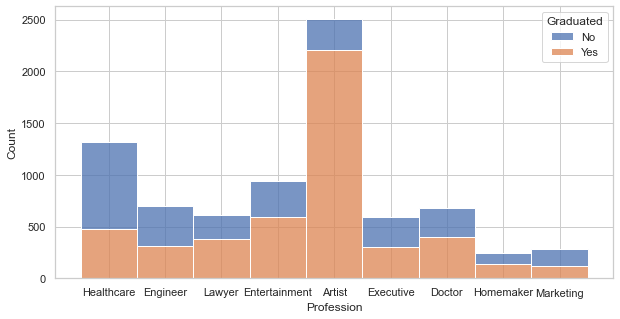

In [67]:
f, ax2 = plt.subplots(figsize=(10, 5))
ax2 = sns.histplot(df, x="Profession", hue="Graduated", multiple="stack")

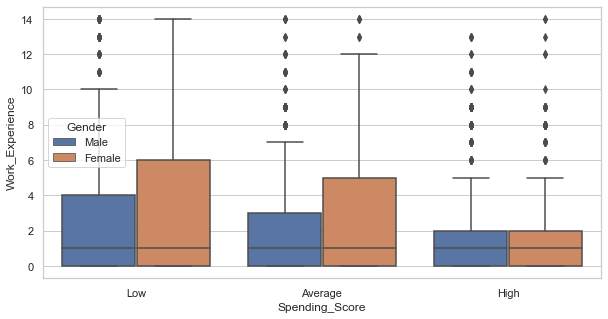

In [68]:
sns.set_theme(style="whitegrid")
f, ax3 = plt.subplots(figsize=(10, 5))
ax3 = sns.boxplot(x="Spending_Score", hue="Gender", y="Work_Experience", data=df)

## Outliers and missing values
You should determine if your data has outliers or needs to be cleaned in any way. Are there missing data values for specific factors? How will you handle the data cleaning? Will you discard, interpolate or otherwise substitute data values?


In [69]:
df.isna().sum(axis=0)

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

In [70]:
# remove dupulicates
df.drop_duplicates(inplace=True)

# delete ID colum as it's not important
df.drop(["ID"], axis=1, inplace=True)

# remove missing values
df.dropna(subset=["Profession"],inplace=True)
df.dropna(subset=["Var_1"], inplace=True)

# inputed missing values
df["Ever_Married"].fillna("No", inplace=True)
df["Graduated"].fillna("No", inplace=True)

df["Family_Size"].fillna(df["Family_Size"].mean(), inplace=True)

df["Work_Experience"].replace(0, np.nan, inplace=True)
df["Work_Experience"].fillna(df["Work_Experience"].sum() / df["Age"].sum() * df["Age"], inplace=True)

## Data transformation
Determine if any data needs to be transformed. For example, if you're planning on using an SVM method for prediction, you may need to normalize or scale the data if there is a considerable difference in the range of the data.
Using your hypothesis, indicate if it's likely that you should transform data, such as using a log transform or other transformation of the dataset.



In [71]:
df = pd.concat([df, pd.get_dummies(df["Gender"], prefix="Gender")], axis=1)
df = pd.concat([df, pd.get_dummies(df["Ever_Married"], prefix="Ever_Married")], axis=1)
df = pd.concat([df, pd.get_dummies(df["Graduated"], prefix="Graduated")], axis=1)
df = pd.concat([df, pd.get_dummies(df["Profession"], prefix="Profession")], axis=1)
df = pd.concat([df, pd.get_dummies(df["Var_1"], prefix="Var_1")], axis=1)

df["Spending_Score_Level"] = df["Spending_Score"].apply(lambda x: ["Low", "Average", "High"].index(x))+1
df["Segmentation_Level"] = df["Segmentation"].apply(lambda x: ["A", "B", "C", "D"].index(x))+1

df.drop(["Segmentation", "Gender", "Ever_Married", "Graduated", "Profession", "Spending_Score", "Var_1"], axis=1, inplace=True)


## Correction between factor
Describe correlations between different factors of the dataset and justify your assumption that they are correlated or not correlated. You may use numeric or qualitative/graphical analysis for this step.


<AxesSubplot:>

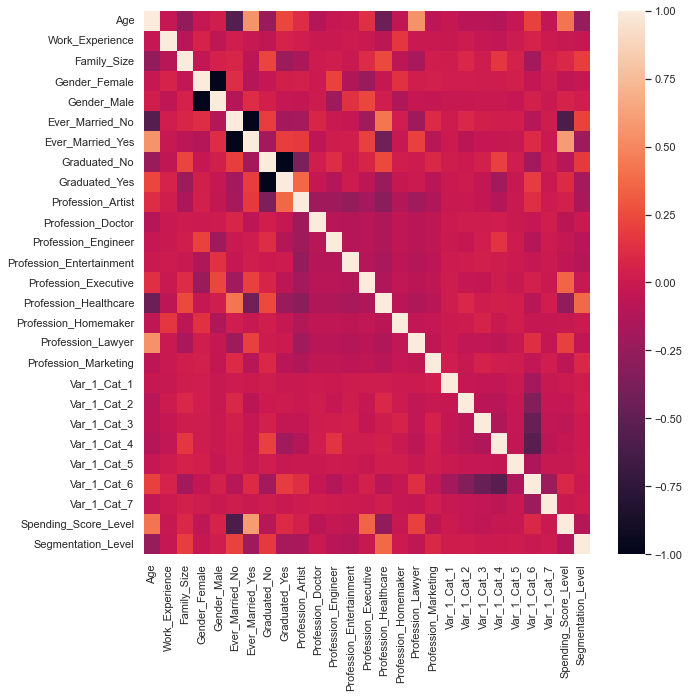

In [72]:
fig, ax = plt.subplots(1, figsize=(10,10))
sns.heatmap(df.corr())

# 4. Perform Analysis Using Unsupervised Learning Models, Present Discussion, and Conclusions

## Data Modeling

In [100]:
df_features = df.loc[:,'Age':'Spending_Score_Level']
df_targets = df.loc[:,'Segmentation_Level']
x_train, x_test, y_train, y_test = train_test_split(df_features, df_targets, test_size=0.3)
x_train.shape

(5509, 26)

In [142]:
def label_permute_compare(y_true, y_pred):

    all_permuation = list(itertools.permutations([1, 2, 3, 4],4))
    all_dict = []
    a = (0,1,2,3)
    
    for i in range(len(all_permuation)):
        all_dict.append(dict(zip(a, all_permuation[i])))
    
    all_results=[]
    for i in range(len(all_dict)):
        i_result = []
        i_result.append(all_dict[i])
        new_pred = np.vectorize(all_dict[i].get)(y_pred)
        acc = accuracy_score(y_true,new_pred)
        i_result.append(acc)
        all_results.append(i_result)
    sort_res = sorted(all_results, key=lambda x:x[1])
    sort_res = sort_res[::-1]
    label_order = sort_res[0][0].values()
    acc = sort_res[0][1]
    return label_order,acc

In [174]:
reduced_data_train = PCA(n_components=10).fit_transform(x_train)
reduced_data_test = PCA(n_components=10).fit_transform(x_test)
kmeans = KMeans(init="k-means++", n_clusters=4, n_init=4)
kmeans.fit_predict(reduced_data_train)

array([3, 3, 3, ..., 1, 3, 3], dtype=int32)

In [160]:
y_pred = kmeans.labels_
label_permute_compare(y_train, y_pred)

(dict_values([4, 3, 2, 1]), 0.41296060991105465)

In [176]:
y_pred_test = kmeans.predict(reduced_data_test)
label_permute_compare(y_test, y_pred_test)

(dict_values([3, 4, 2, 1]), 0.4394580863674852)

## Compare Models
show your understanding of why specific models work better than the other or what limitations or cautions specific models may have.

In [ ]:
depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
xgbc_train_result = []
xgbc_test_result = []
for a in depths:
    model_xgbc = XGBClassifier(max_depth=a, objective="multi:softmax", num_class=4, random_state=0).fit(x_train, y_train)

    train_res = []
    y_preds_train = model_xgbc.predict(x_train)
    accuracy_train = accuracy_score(y_train, y_preds_train)
    train_res.append(accuracy_train)
    xgbc_train_result.append(train_res)

    test_res = []
    y_preds_test = model_xgbc.predict(x_test)
    accuracy_test = accuracy_score(y_test, y_preds_test)
    test_res.append(accuracy_test)
    xgbc_test_result.append(test_res)

In [187]:
xgbc_train_result

[[0.5247776365946633],
 [0.5707024868397168],
 [0.6157197313487022],
 [0.676529315665275],
 [0.7442367035759666],
 [0.8130332183699401],
 [0.8838264657832637],
 [0.9203122163732075],
 [0.9468143038664004],
 [0.9562534035215102]]

In [186]:
xgbc_test_result

[[0.5347163420829806],
 [0.5389500423370025],
 [0.5385266723116003],
 [0.5309060118543607],
 [0.5182049110922947],
 [0.5088907705334462],
 [0.4966130397967824],
 [0.48814563928873833],
 [0.48221845893310755],
 [0.48052497883149875]]

## Model improvements

In [191]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

    
def objective(space):
    clf=XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( x_train, y_train), ( x_test, y_test)]
    
    clf.fit(x_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

In [193]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)


The best hyperparameters are :  

{'colsample_bytree': 0.5081764315836226, 'gamma': 1.6919930108701786, 'max_depth': 17.0, 'min_child_weight': 8.0, 'reg_alpha': 157.0, 'reg_lambda': 0.8328080064411347}


In [ ]:
best_model = XGBClassifier(best_hyperparams).fit(x_train, y_train)
y_preds_train = best_model.predict(x_train)
accuracy_train = accuracy_score(y_train, y_preds_train)
y_preds_test = best_model.predict(x_test)
accuracy_test = accuracy_score(y_test, y_preds_test)

In [197]:
accuracy_train

0.8130332183699401